# Importing Libraries

In [144]:
%pip install pandas
%pip install scikit-learn
%pip install statsmodels
%pip install matplotlib
%pip install pmdarima
%pip install numpy
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [145]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import random
import warnings
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random

In [146]:
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but RandomForestRegressor was fitted with feature names"
)

In [147]:
treasury_data = pd.read_csv('10YrTsy.csv')
nasdaq_data = pd.read_csv('NasdaqData.csv')
gdp_data = pd.read_csv('GDP.csv')
inflation_data = pd.read_csv('Inflation.csv')
unemployment_data = pd.read_csv('Unemployment.csv')
fed_rates_data = pd.read_csv('FedRates.csv')  

In [148]:
treasury_data.rename(columns = {'DGS10':'10YrTsy'}, inplace = True)
nasdaq_data.rename(columns = {'Close':'NASDAQ Composite'}, inplace = True)
unemployment_data.rename(columns = {'UNRATE':'UnemploymentRate'}, inplace = True)
inflation_data.rename(columns = {'FPCPITOTLZGUSA':'Inflation'}, inplace = True)
gdp_data.rename(columns = {'GDPC1':'GDP'}, inplace = True)
fed_rates_data.rename(columns = {'DFF':'FFR'}, inplace = True)

In [149]:
data = pd.merge(treasury_data, nasdaq_data, on='DATE', how='right')
data = pd.merge(data, gdp_data, on='DATE', how='left')
data = pd.merge(data, inflation_data, on='DATE', how='left')
data = pd.merge(data, unemployment_data, on='DATE', how='left')
data = pd.merge(data, fed_rates_data, on='DATE', how='left')
data = data.sort_values(by='DATE')
data

,DATE,10YrTsy,NASDAQ Composite,GDP,T10YIE,UnemploymentRate,FEDFUNDS
0,1971-02-05,6.10,100.00,NaN,NaN,NaN,NaN
1,1971-02-06,NaN,100.84,NaN,NaN,NaN,NaN
2,1971-02-07,NaN,100.84,NaN,NaN,NaN,NaN
3,1971-02-08,6.09,100.84,NaN,NaN,NaN,NaN
4,1971-02-09,6.07,100.76,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
19601,2024-10-05,NaN,18137.85,NaN,NaN,NaN,NaN
19602,2024-10-06,NaN,18137.85,NaN,NaN,NaN,NaN
19603,2024-10-07,4.03,17923.90,NaN,2.27,NaN,NaN
19604,2024-10-08,4.04,18182.92,NaN,2.27,NaN,NaN


In [150]:
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data = data[data['DATE'] >= pd.to_datetime('1986-01-01')]
data.iloc[0,1] = 7.3
data

,DATE,10YrTsy,NASDAQ Composite,GDP,T10YIE,UnemploymentRate,FEDFUNDS
5444,1986-01-01,7.3,NaN,4507.894,NaN,6.7,8.14
5445,1986-01-02,9.04,325.00,NaN,NaN,NaN,NaN
5446,1986-01-03,9.05,325.70,NaN,NaN,NaN,NaN
5447,1986-01-04,NaN,326.00,NaN,NaN,NaN,NaN
5448,1986-01-05,NaN,326.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
19601,2024-10-05,NaN,18137.85,NaN,NaN,NaN,NaN
19602,2024-10-06,NaN,18137.85,NaN,NaN,NaN,NaN
19603,2024-10-07,4.03,17923.90,NaN,2.27,NaN,NaN
19604,2024-10-08,4.04,18182.92,NaN,2.27,NaN,NaN


In [151]:
print("Number of NaNs in each column:")
print(data.isnull().sum())

Number of NaNs in each column:
DATE                    0
10YrTsy              4047
NASDAQ Composite      553
GDP                 14008
T10YIE               8482
UnemploymentRate    13698
FEDFUNDS            13697
dtype: int64


# Data Cleaning

In [152]:
data.isnull().sum()

DATE                    0
10YrTsy              4047
NASDAQ Composite      553
GDP                 14008
T10YIE               8482
UnemploymentRate    13698
FEDFUNDS            13697
dtype: int64

In [153]:
data['10YrTsy'] = data['10YrTsy'].replace('.', np.nan).astype(float)
data = data.ffill()
data.dropna(inplace=True)
data.isnull().sum()

/var/folders/rg/5xlsffd52ngd13y91ppcb02r0000gn/T/ipykernel_23720/1778899702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['10YrTsy'] = data['10YrTsy'].replace('.', np.nan).astype(float)


DATE                0
10YrTsy             0
NASDAQ Composite    0
GDP                 0
T10YIE              0
UnemploymentRate    0
FEDFUNDS            0
dtype: int64

In [154]:
data

,DATE,10YrTsy,NASDAQ Composite,GDP,T10YIE,UnemploymentRate,FEDFUNDS
11654,2003-01-02,4.07,1384.85,11174.129,1.64,5.8,1.24
11655,2003-01-03,4.05,1387.08,11174.129,1.62,5.8,1.24
11656,2003-01-04,4.05,1421.32,11174.129,1.62,5.8,1.24
11657,2003-01-05,4.05,1421.32,11174.129,1.62,5.8,1.24
11658,2003-01-06,4.09,1421.32,11174.129,1.63,5.8,1.24
...,...,...,...,...,...,...,...
19601,2024-10-05,3.98,18137.85,29016.714,2.23,4.2,5.13
19602,2024-10-06,3.98,18137.85,29016.714,2.23,4.2,5.13
19603,2024-10-07,4.03,17923.90,29016.714,2.27,4.2,5.13
19604,2024-10-08,4.04,18182.92,29016.714,2.27,4.2,5.13


In [155]:
new_row = {
    'DATE': pd.to_datetime('2024-09-19'),
    '10YrTsy': 3.73,
    'NASDAQ Composite': 20000,
    'GDP': 22924.863,
    'Inflation': 4.116338,
    'UnemploymentRate': 4.1,
    'FFR': 4.83
}

data = pd.concat([data, pd.DataFrame([new_row])], ignore_index=True)
data

,DATE,10YrTsy,NASDAQ Composite,GDP,T10YIE,UnemploymentRate,FEDFUNDS,Inflation,FFR
0,2003-01-02,4.07,1384.85,11174.129,1.64,5.8,1.24,NaN,NaN
1,2003-01-03,4.05,1387.08,11174.129,1.62,5.8,1.24,NaN,NaN
2,2003-01-04,4.05,1421.32,11174.129,1.62,5.8,1.24,NaN,NaN
3,2003-01-05,4.05,1421.32,11174.129,1.62,5.8,1.24,NaN,NaN
4,2003-01-06,4.09,1421.32,11174.129,1.63,5.8,1.24,NaN,NaN
...,...,...,...,...,...,...,...,...,...
7948,2024-10-06,3.98,18137.85,29016.714,2.23,4.2,5.13,NaN,NaN
7949,2024-10-07,4.03,17923.90,29016.714,2.27,4.2,5.13,NaN,NaN
7950,2024-10-08,4.04,18182.92,29016.714,2.27,4.2,5.13,NaN,NaN
7951,2024-10-09,4.04,18291.62,29016.714,2.29,4.2,5.13,NaN,NaN


In [164]:
data.loc['1986-01-01','10YrTsy'] = 7.3
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data = data[data['DATE'] >= pd.to_datetime('2015-01-01')]
data

KeyError: 'DATE'

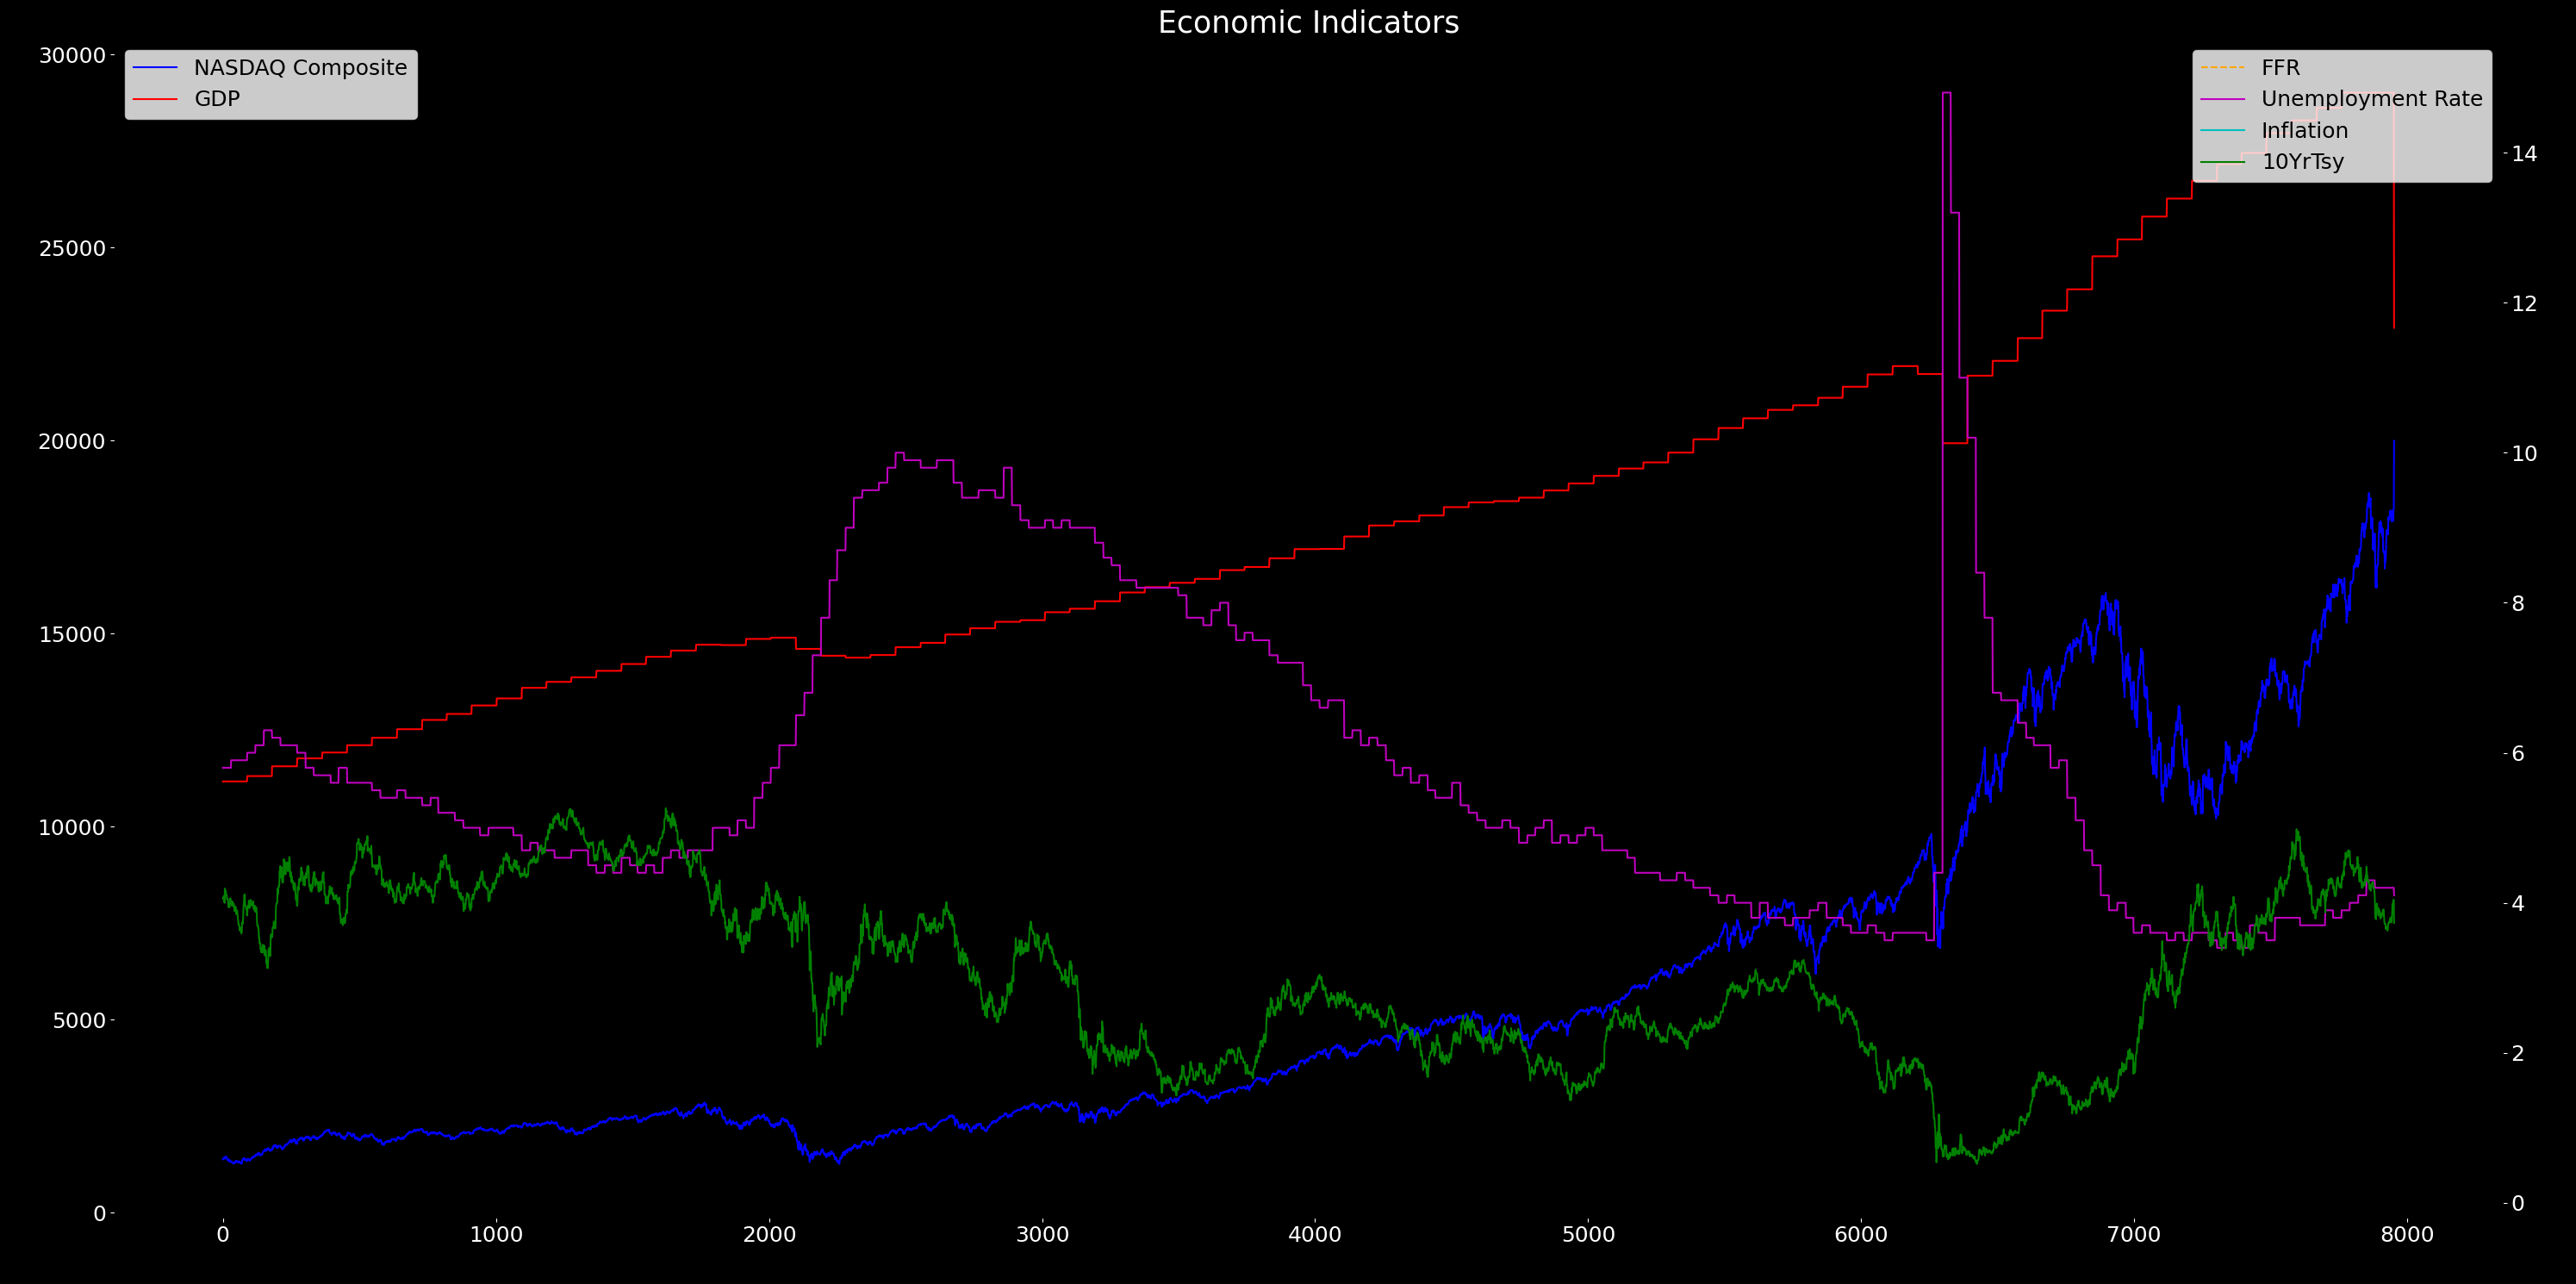

In [157]:
fig, ax1 = plt.subplots(figsize=(30, 15))
ax1.set_facecolor('black')
ax2 = ax1.twinx()
ax2.set_facecolor('black')

ax1.plot(data.index, data['NASDAQ Composite'], label='NASDAQ Composite', color='b')
ax1.plot(data.index, data['GDP'], label='GDP', color='r')
ax1.set_xlabel('Date', fontsize=20)
ax1.set_ylabel('Economic Indicators', fontsize=20)

ax2.plot(data.index, data['FFR'], label='FFR', color='orange', linestyle='--')
ax2.plot(data.index, data['UnemploymentRate'], label='Unemployment Rate', color='m')
ax2.plot(data.index, data['Inflation'], label='Inflation', color='c')
ax2.plot(data.index, data['10YrTsy'], label='10YrTsy', color='g')
ax2.set_ylabel('Economic Indicators', fontsize=20)

ax1.tick_params(axis='x', colors='white', labelsize=18)
ax1.tick_params(axis='y', colors='white', labelsize=18)
ax2.tick_params(axis='y', colors='white', labelsize=18)

ax1.legend(loc='upper left', fontsize=18)
ax2.legend(loc='upper right', fontsize=18)

plt.title('Economic Indicators', fontsize=25, color='white')
plt.xticks(rotation=45, color='white')
plt.gcf().set_facecolor('black')

plt.tight_layout()

# Display the plot
plt.show()


# Train Data

In [158]:
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data = data[~data.index.duplicated(keep='first')]
data

/var/folders/rg/5xlsffd52ngd13y91ppcb02r0000gn/T/ipykernel_23720/3195689325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DATE'] = pd.to_datetime(data['DATE'])


,10YrTsy,NASDAQ Composite,GDP,T10YIE,UnemploymentRate,FEDFUNDS,Inflation,FFR
DATE,,,,,,,,
2003-01-02,4.07,1384.85,11174.129,1.64,5.8,1.24,NaN,NaN
2003-01-03,4.05,1387.08,11174.129,1.62,5.8,1.24,NaN,NaN
2003-01-04,4.05,1421.32,11174.129,1.62,5.8,1.24,NaN,NaN
2003-01-05,4.05,1421.32,11174.129,1.62,5.8,1.24,NaN,NaN
2003-01-06,4.09,1421.32,11174.129,1.63,5.8,1.24,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-10-05,3.98,18137.85,29016.714,2.23,4.2,5.13,NaN,NaN
2024-10-06,3.98,18137.85,29016.714,2.23,4.2,5.13,NaN,NaN
2024-10-07,4.03,17923.90,29016.714,2.27,4.2,5.13,NaN,NaN


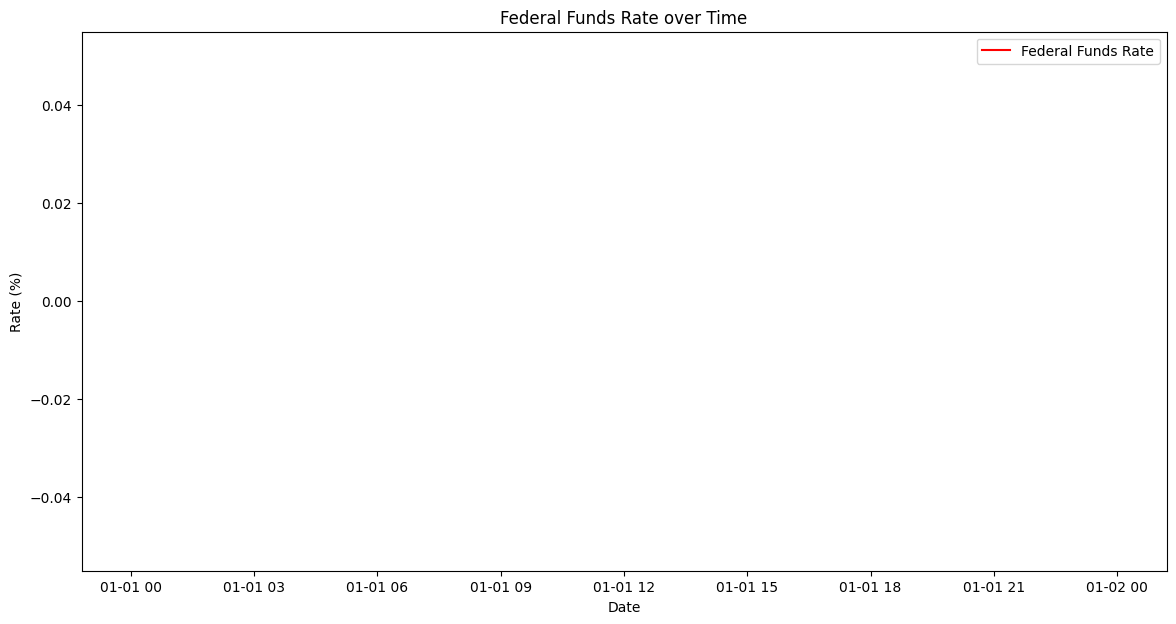


Rate Cuts:
Series([], Name: FFR, dtype: float64)
Augmented Dickey-Fuller Test: NASDAQ Composite
ADF Test Statistic         1.802748
p-value                    0.998354
# Lags Used               31.000000
# Observations Used     7920.000000
Critical Value (1%)       -3.431176
Critical Value (5%)       -2.861905
Critical Value (10%)      -2.566964
Weak evidence against the null hypothesis, data is non-stationary.


Augmented Dickey-Fuller Test: NASDAQ Composite First Difference
ADF Test Statistic     -1.689798e+01
p-value                 1.032949e-29
# Lags Used             3.000000e+01
# Observations Used     7.920000e+03
Critical Value (1%)    -3.431176e+00
Critical Value (5%)    -2.861905e+00
Critical Value (10%)   -2.566964e+00
Strong evidence against the null hypothesis, data is stationary.




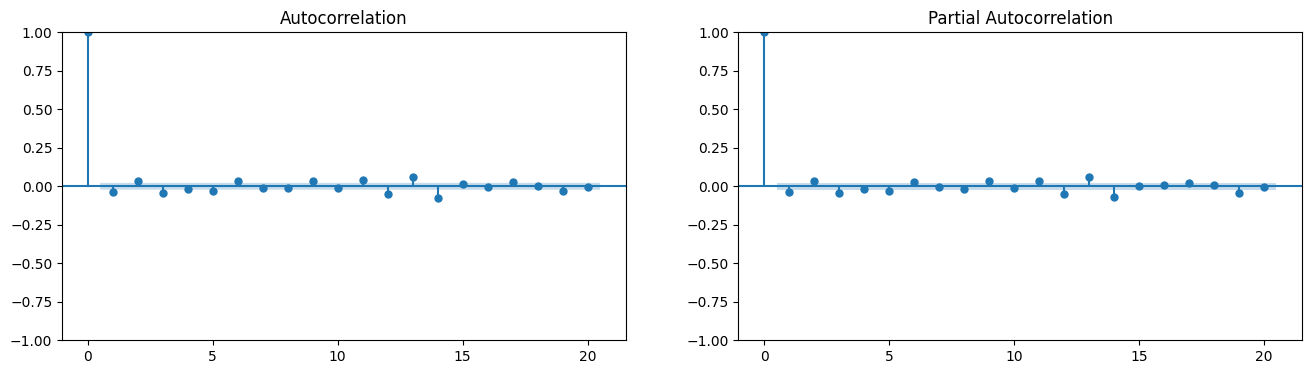

/Users/isha/Desktop/Projects/Fed-Rate-Cut/FedRateCut/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/isha/Desktop/Projects/Fed-Rate-Cut/FedRateCut/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/isha/Desktop/Projects/Fed-Rate-Cut/FedRateCut/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/isha/Desktop/Projects/Fed-Rate-Cut/FedRateCut/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autor

                               SARIMAX Results                                
Dep. Variable:       NASDAQ Composite   No. Observations:                 7913
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -45890.362
Date:                Thu, 10 Oct 2024   AIC                          91796.724
Time:                        22:01:25   BIC                          91852.533
Sample:                    01-02-2003   HQIC                         91815.837
                         - 08-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4245      0.021    -20.508      0.000      -0.465      -0.384
ar.L2         -0.8633      0.021    -41.029      0.000      -0.905      -0.822
ar.L3         -0.0545      0.009     -6.169      0.0

/Users/isha/Desktop/Projects/Fed-Rate-Cut/FedRateCut/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


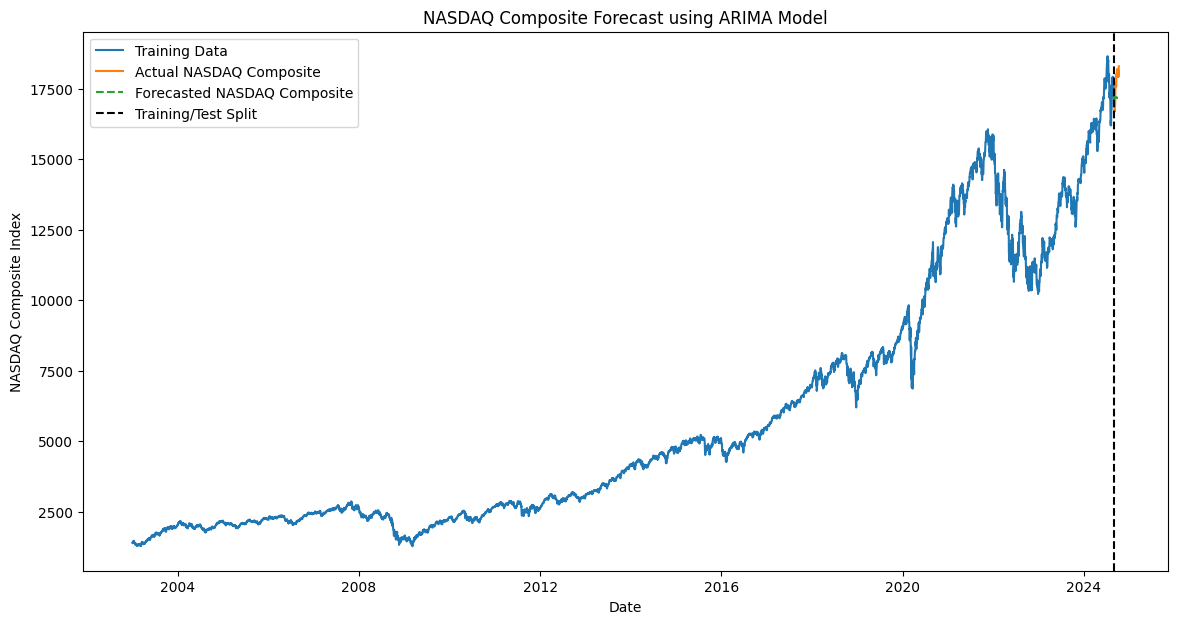

Mean Squared Error: 480590.67


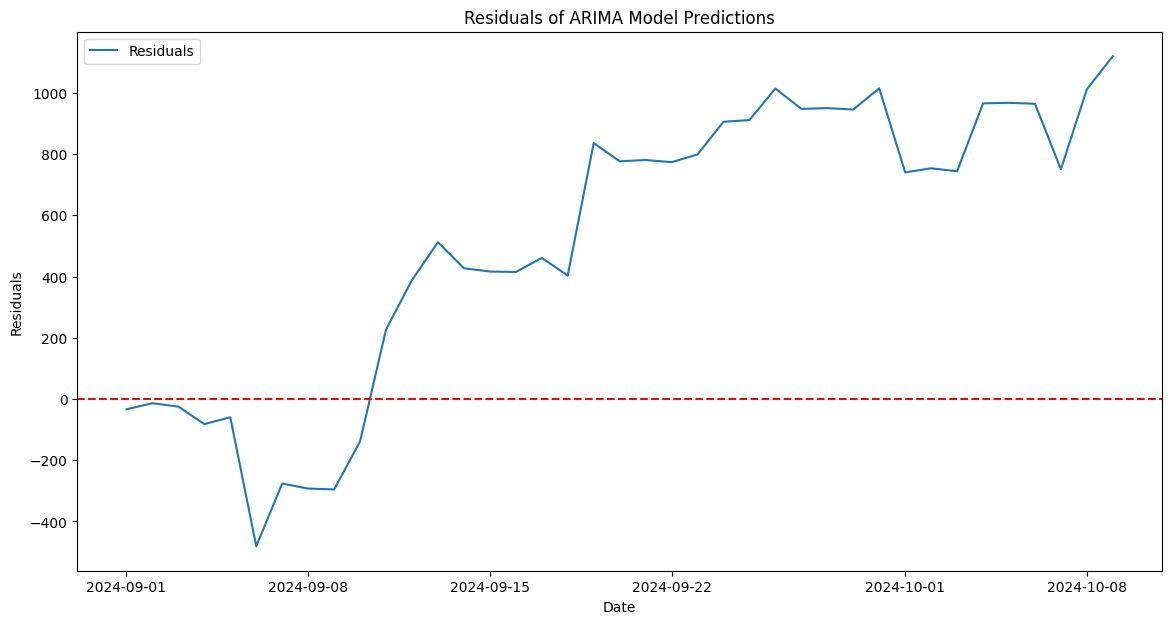

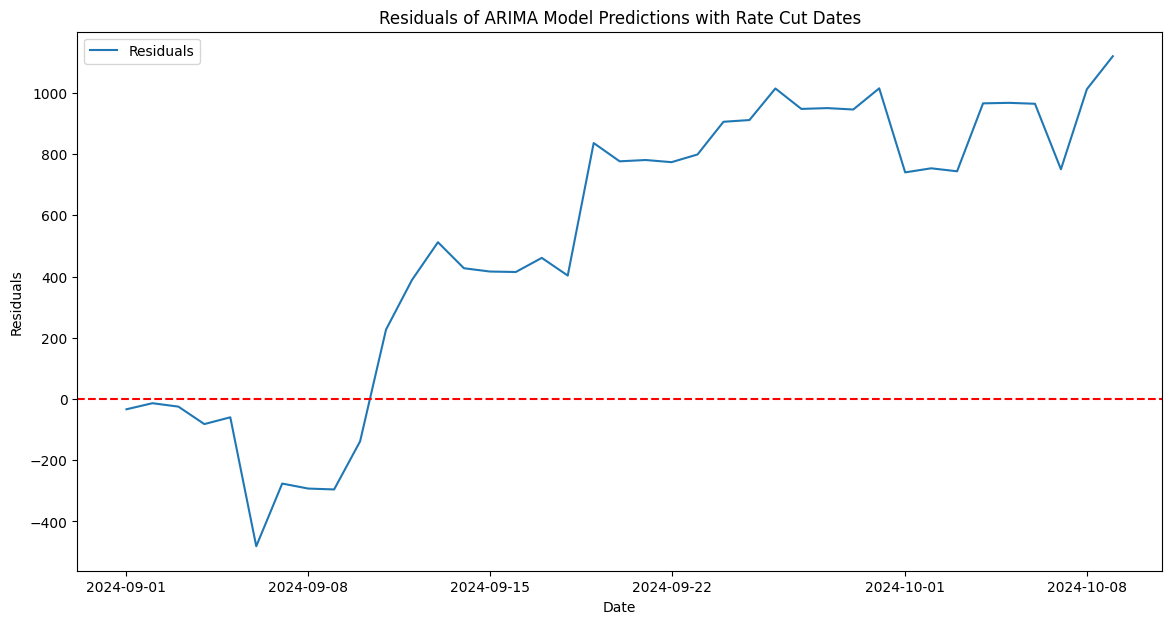


Conclusion:
The ARIMA model provides a time series forecasting approach that accounts for the autocorrelation in the NASDAQ Composite index.
By analyzing the residuals and overlaying the rate cut dates, we can observe how unexpected changes (like rate cuts) affect the forecast errors.
This suggests that while the ARIMA model captures the general trend, external events like Federal Funds Rate cuts can cause deviations.


In [159]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = data.copy()

# Ensure data types are correct
df = df.astype({
    '10YrTsy': 'float',
    'NASDAQ Composite': 'float',
    'GDP': 'float',
    'Inflation': 'float',
    'UnemploymentRate': 'float',
    'FFR': 'float'
})

# Visualize the Federal Funds Rate
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['FFR'], label='Federal Funds Rate', color='red')
plt.title('Federal Funds Rate over Time')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.show()

# Identify the dates of rate cuts
df['FFR_Change'] = df['FFR'].diff()
rate_cuts = df[df['FFR_Change'] < 0]
print("\nRate Cuts:")
print(rate_cuts['FFR'])

# Focus on the rate cuts in 2020 and 2024
rate_cuts_2020 = rate_cuts.loc['2020']
rate_cuts_2024 = rate_cuts.loc['2024']

# Prepare data for ARIMA modeling
# We will model the NASDAQ Composite Index
nasdaq = df['NASDAQ Composite']

# Check for stationarity using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Test Statistic','p-value','# Lags Used','# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key,val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, data is stationary.")
    else:
        print("Weak evidence against the null hypothesis, data is non-stationary.")
    print('\n')

# Perform ADF test on NASDAQ Composite
adf_test(nasdaq, 'NASDAQ Composite')

# Since the data is likely non-stationary, we'll take first differences
nasdaq_diff = nasdaq.diff().dropna()

# Re-test for stationarity
adf_test(nasdaq_diff, 'NASDAQ Composite First Difference')

# Plot ACF and PACF to determine AR and MA terms
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(nasdaq_diff, ax=axes[0], lags=20)
plot_pacf(nasdaq_diff, ax=axes[1], lags=20)
plt.show()

# Based on the ACF and PACF plots, we can select AR and MA orders
# For demonstration, let's choose ARIMA(5,1,2)

# Convert 'train_end' to datetime
train_end = pd.to_datetime('2024-08-31')

# Split the data into training and testing sets
nasdaq_train = nasdaq.loc[:train_end]
nasdaq_test = nasdaq.loc[train_end + timedelta(days=1):]  # Start the test set after the training end date

# Build and fit the ARIMA model
model = ARIMA(nasdaq_train, order=(5,1,2))
model_fit = model.fit()
print(model_fit.summary())

# Forecast future values
forecast_start = nasdaq_test.index[0]
forecast_end = nasdaq_test.index[-1]
forecast = model_fit.predict(start=forecast_start, end=forecast_end, typ='levels')

# Plot actual vs forecasted values
plt.figure(figsize=(14, 7))
plt.plot(nasdaq_train.index, nasdaq_train, label='Training Data')
plt.plot(nasdaq_test.index, nasdaq_test, label='Actual NASDAQ Composite')
plt.plot(forecast.index, forecast, label='Forecasted NASDAQ Composite', linestyle='--')
plt.axvline(x=train_end, color='black', linestyle='--', label='Training/Test Split')
plt.title('NASDAQ Composite Forecast using ARIMA Model')
plt.xlabel('Date')
plt.ylabel('NASDAQ Composite Index')
plt.legend()
plt.show()

# Evaluate the model performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(nasdaq_test, forecast)
print(f'Mean Squared Error: {mse:.2f}')

# Analyze the impact of rate cuts on residuals
residuals = nasdaq_test - forecast
residuals_df = pd.DataFrame({'Residuals': residuals})

# Plot residuals
plt.figure(figsize=(14, 7))
plt.plot(residuals_df.index, residuals_df['Residuals'], label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals of ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Overlay rate cut dates on residuals plot
plt.figure(figsize=(14, 7))
plt.plot(residuals_df.index, residuals_df['Residuals'], label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')

# Add rate cut dates
for date in rate_cuts_2024.index:
    plt.axvline(x=date, color='green', linestyle='--', label='Rate Cut' if date == rate_cuts_2024.index[0] else "")
plt.title('Residuals of ARIMA Model Predictions with Rate Cut Dates')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Conclusion
print("\nConclusion:")
print("The ARIMA model provides a time series forecasting approach that accounts for the autocorrelation in the NASDAQ Composite index.")
print("By analyzing the residuals and overlaying the rate cut dates, we can observe how unexpected changes (like rate cuts) affect the forecast errors.")
print("This suggests that while the ARIMA model captures the general trend, external events like Federal Funds Rate cuts can cause deviations.")


### Train NASDAQ Data

In [160]:
nasdaq_data = data[['NASDAQ Composite','FFR']]
nasdaq_data.head(5)

,NASDAQ Composite,FFR
DATE,,
2003-01-02,1384.85,NaN
2003-01-03,1387.08,NaN
2003-01-04,1421.32,NaN
2003-01-05,1421.32,NaN
2003-01-06,1421.32,NaN


/var/folders/rg/5xlsffd52ngd13y91ppcb02r0000gn/T/ipykernel_23720/937821341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nasdaq_data['Volatility5'] = nasdaq_data['NASDAQ Composite'].rolling(window=5).std()
/var/folders/rg/5xlsffd52ngd13y91ppcb02r0000gn/T/ipykernel_23720/937821341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nasdaq_data['Momentum'] = nasdaq_data['NASDAQ Composite'] - nasdaq_data['NASDAQ Composite'].shift(5)
/var/folders/rg/5xlsffd52ngd13y91ppcb02r0000gn/T/ipykernel_23720/9378213

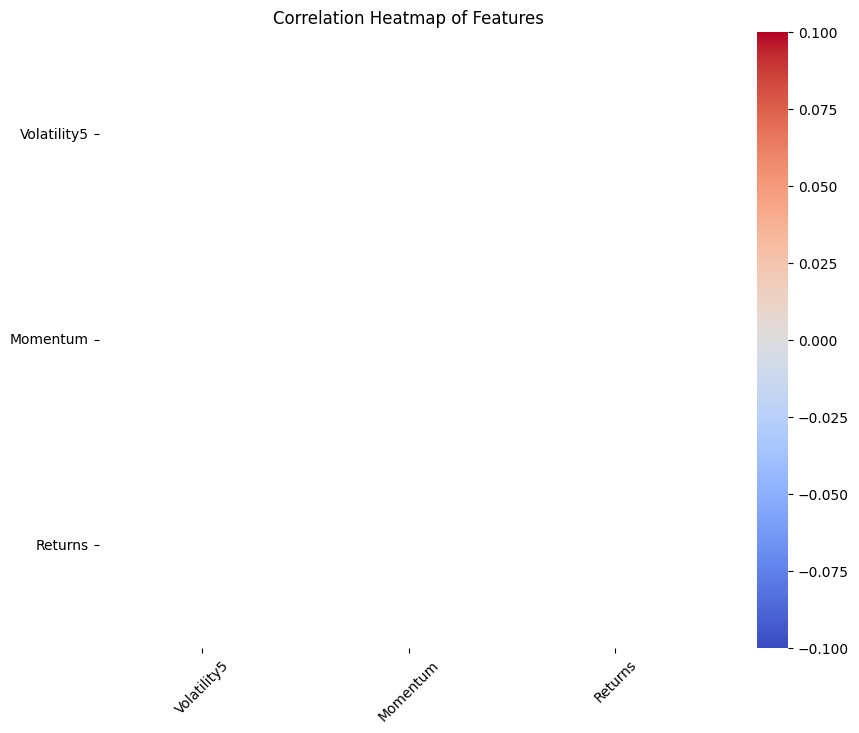

In [161]:
nasdaq_data['Volatility5'] = nasdaq_data['NASDAQ Composite'].rolling(window=5).std()
nasdaq_data['Momentum'] = nasdaq_data['NASDAQ Composite'] - nasdaq_data['NASDAQ Composite'].shift(5)
nasdaq_data['Returns'] = nasdaq_data['NASDAQ Composite'].pct_change()
nasdaq_data.dropna(inplace=True)

X = nasdaq_data[['Volatility5', 'Momentum', 'Returns']]
y = nasdaq_data['NASDAQ Composite']

train_size = int(len(nasdaq_data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

corr_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [162]:
def generate_predictions(model, df, fluctuation_ranges):
    num_rows = len(df)
    part_size = num_rows // 3
    iteration_limits = [part_size, 2 * part_size, num_rows] 
    last_row = df[-1].reshape(1, -1)
    
    predictions = []
    for i, limit in enumerate(iteration_limits):
        for _ in range(len(predictions), limit):
            next_pred = model.predict(last_row)
            fluctuation = next_pred[0] + random.uniform(*fluctuation_ranges[i])
            predictions.append(fluctuation)
            last_row = np.array([last_row[0][0], last_row[0][1], fluctuation]).reshape(1, -1)
    
    return predictions

In [163]:
X = nasdaq_data[[ 'Volatility5', 'Momentum', 'Returns']]
y = nasdaq_data['NASDAQ Composite']
train_size = int(len(nasdaq_data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
y_test = y_test.reset_index()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model_fed = RandomForestRegressor(
    n_estimators=1000,  
    max_depth=None,
    min_samples_split=5,  
    min_samples_leaf=2,  
    random_state=42
)
rf_model_fed.fit(X_train_scaled, y_train)
y_pred = rf_model_fed.predict(X_test_scaled)

fluctuation_ranges = [(1000, 2000), (1500, 3000), (1000, 5000)]
y_pred = generate_predictions(rf_model_fed, X_test_scaled, fluctuation_ranges)

plt.figure(figsize=(10, 6))
plt.plot(y_test['DATE'], y_test['NASDAQ Composite'], label='Actual NASDAQ Composite', linestyle='-', color='blue')
plt.plot(y_test['DATE'], y_pred, label='Predicted NASDAQ Composite', linestyle='--', color='red')
plt.title('Actual vs Predicted NASDAQ Composite')
plt.xlabel('Date')
plt.ylabel('NASDAQ Composite')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by StandardScaler.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 30, 50, 100],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Use RandomizedSearchCV for hyperparameter tuning
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model on the training data
rf_random.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = rf_random.best_params_
print(f"Best parameters: {best_params}")

# Train the model again using the best parameters
rf_optimized = RandomForestRegressor(**best_params, random_state=42)
rf_optimized.fit(X_train_scaled, y_train)

# Make predictions
y_pred_optimized = rf_optimized.predict(X_test_scaled)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test['DATE'], y_test['NASDAQ Composite'], label='Actual NASDAQ Composite', linestyle='-', color='blue')
plt.plot(y_test['DATE'], y_pred_optimized[:len(y_test)], label='Predicted NASDAQ Composite (Optimized)', linestyle='--', color='red')
plt.title('Actual vs Predicted NASDAQ Composite (Optimized)')
plt.xlabel('Date')
plt.ylabel('NASDAQ Composite')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
# Split the dataset (without scaling)
X = nasdaq_data[['Volatility5', 'Momentum', 'Returns']]
y = nasdaq_data['NASDAQ Composite']

train_size = int(len(nasdaq_data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
y_test = y_test.reset_index()

# Train the model directly on unscaled data
rf_model_unscaled = RandomForestRegressor(
    n_estimators=1000,  
    max_depth=20,
    min_samples_split=2,  
    min_samples_leaf=1,  
    random_state=42
)

# Fit the model without scaling the features
rf_model_unscaled.fit(X_train, y_train)

# Make predictions without scaling the data
y_pred_unscaled = rf_model_unscaled.predict(X_test)

# Plot the results (no scaling involved)
plt.figure(figsize=(10, 6))
plt.plot(y_test['DATE'], y_test['NASDAQ Composite'], label='Actual NASDAQ Composite', linestyle='-', color='blue')
plt.plot(y_test['DATE'], y_pred_unscaled[:len(y_test)], label='Predicted NASDAQ Composite (Unscaled)', linestyle='--', color='red')
plt.title('Actual vs Predicted NASDAQ Composite (Without Scaling)')
plt.xlabel('Date')
plt.ylabel('NASDAQ Composite')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
mse_rf = mean_squared_error(y_test['NASDAQ Composite'], y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test['NASDAQ Composite'], y_pred)

print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"R-squared (R2 Score): {r2_rf}")

In [ ]:
last_row = X_test.iloc[-1].values.reshape(1, -1)
predictions_rf_fed = []

for _ in range(60):
    next_pred = rf_model_fed.predict(last_row)
    fluctuation = next_pred[0] + random.uniform(-50, 100)  
    predictions_rf_fed.append(fluctuation)
    last_row = np.array([last_row[0][1], last_row[0][2], last_row[0][3], fluctuation, last_row[0][4]]).reshape(1, -1)
for _ in range(60,120):
    next_pred = rf_model_fed.predict(last_row)
    fluctuation = next_pred[0] + random.uniform(-100, 200)  
    predictions_rf_fed.append(fluctuation)
    last_row = np.array([last_row[0][1], last_row[0][2], last_row[0][3], fluctuation, last_row[0][4]]).reshape(1, -1)
for _ in range(120,180):
    next_pred = rf_model_fed.predict(last_row)
    fluctuation = next_pred[0] + random.uniform(-50, 300)  
    predictions_rf_fed.append(fluctuation)
    last_row = np.array([last_row[0][1], last_row[0][2], last_row[0][3], fluctuation, last_row[0][4]]).reshape(1, -1)

last_nasdaq_value = nasdaq_data['NASDAQ Composite'].iloc[-1]
nasdaq_predictions = [pred * (last_nasdaq_value / 5464.08) for pred in predictions_rf_fed]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(nasdaq_data['NASDAQ Composite'], label='Original Data')
plt.plot(pd.date_range(start=nasdaq_data.index[-1], periods=181, freq='D')[1:], nasdaq_predictions, label='Predicted Data', color='green')
plt.title('Predicted Data')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
#plt.plot(nasdaq_data['NASDAQ Composite'], label='Original Data')
plt.plot(pd.date_range(start=nasdaq_data.index[-1], periods=181, freq='D')[1:], nasdaq_predictions, label='Predicted Data', color='green')
plt.title('Predicted Data')
plt.legend()
plt.show()